# Classification and Distribution of M-Type Asteroids
## Introduction to Data Science (MATH 4100/COMP 5360) Final Project
## Matt Storie and Ian Wixom
---
## Part 0: Setup and Reading in Data

In [2]:
#Import and Setup
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

#Custom Functions for use later
#Increases print output for one printing
def print_all(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')


In [3]:
#Imports are large so I am keeping them in their own cell for now
astro1 = pd.read_csv('C:/Users/matts/ds/Classification-and-Analysis-of-M-type-Asteroids/split_astro_ds_1.csv', low_memory = False)
astro2 = pd.read_csv('C:/Users/matts/ds/Classification-and-Analysis-of-M-type-Asteroids/split_astro_ds_2.csv', low_memory = False)

In [4]:
# Data Frame Formatting
# The Second file did not have all of the same columns, so we are adding them now
# and filling missing values with NA
astro2.columns = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'n_obs_used', 'H',
       'diameter', 'extent', 'albedo', 'rot_per']
astro2['GM'] = np.nan
astro2['BV'] = np.nan
astro2['UB'] = np.nan
astro2['IR'] = np.nan
astro2['spec_B'] = np.nan
astro2['spec_T'] = np.nan
astro = pd.concat([astro1, astro2])

## Part 1 Classification of Unclassified Asteroids
Before we can explore the full set, we are going to need to train a model to classify the unclassified asteroids of the set before exploring the full set. 

In [5]:
# Now that the frames are combined we can perform exploratory analysis
# Examining the number of unclassified asteroids of the dataset
tot_unclassified = len(astro[(astro['spec_T'].isnull()) & (astro['spec_B'].isnull())])
print("There are",len(astro),"total observed objects in the dataset")
print((len(astro)-tot_unclassified), "have been classified, while",tot_unclassified,"remain unclassified.")

# Examing distribution of the classified asteroids
print("---\nSMASS Value Counts")
print(astro['spec_B'].value_counts())
print("---\nTholen Value Counts")
print_all(astro['spec_T'].value_counts())

There are 1048573 total observed objects in the dataset
1742 have been classified, while 1046831 remain unclassified.
---
SMASS Value Counts
S      348
C      139
Ch     135
X      112
Xc      59
B       56
Sl      47
Sq      44
Xk      39
V       35
L       33
K       31
Cb      30
Sa      29
Xe      24
Cgh     15
T       13
Sk      12
A       12
Ld      11
Sr      11
Cg       9
D        8
R        4
O        1
U        1
Name: spec_B, dtype: int64
---
Tholen Value Counts
S         311
C         137
X          51
M          37
D          33
P          33
F          27
XC         22
CX         21
C:         10
E          10
CP         10
G           9
B           8
FC          7
SU          7
PC          6
T           6
CU          5
CX:         5
A           5
ST          5
XFU         5
DU          4
CSU         4
FXU:        4
CG          4
CF          4
CPF         3
DX          3
BU          3
MU          3
GC          3
DP          3
XD          3
CD          3
I           3
XDC 

Now that we have an idea of the distribution, lets subset the metallic identified asteroids, an equal amount of non-metallic asteroids, and use them to build and test a classification model

### Note: Revisit later and see if we can just use the entire classified set as the training. Do the metallic and non-metallic need to be equal?

In [6]:
# Subsetting metal asteroids and getting an equal amount of classified, nonmetal asteroids
classified = astro.loc[(((astro['spec_T'].notnull()) | (astro['spec_B'].notnull())) & astro['albedo'].notnull())]
metal = classified.loc[(classified['spec_T'] == "M") | (classified['spec_B'] == 'X') | 
                   (classified['spec_B'] == 'S') | (classified['spec_T'] == 'S')]
nonmetal = classified.loc[(classified['spec_T'] != "M") & (classified['spec_B'] != 'X') &
                 (classified['spec_B'] != 'S') & (classified['spec_T'] != 'S')]

# Sampling from the nonmetal dataset equally
nonmetal_sample = nonmetal.sample(n=(len(metal)))
metal.insert(20, "m_id", '1')
pd.to_numeric(metal["m_id"])
nonmetal_sample.insert(20, "m_id", '0')
pd.to_numeric(nonmetal_sample["m_id"])
training_set = pd.concat([metal, nonmetal_sample])

In [7]:
# X.head()
# Creating the model
y_var = training_set['m_id'].to_numpy()
np.reshape(y_var, (1, -1))
X_var = training_set['albedo'].to_numpy()
X_var = scale(X_var)

## Preliminary single-variable SVB model
x_train, x_test, y_train, y_test = train_test_split(X_var, y_var, random_state=1, test_size=0.8)
x_train = np.reshape(x_train, ((len(x_train), 1)))
x_test = np.reshape(x_test, ((len(x_test), 1)))


svm_train = svm.SVC(kernel="rbf", C=100, gamma=0.01)
svm_train.fit(x_train, y_train)
test_pred = svm_train.predict(x_test)
print(metrics.confusion_matrix(y_true = y_test, y_pred = test_pred))
print(metrics.accuracy_score(y_true = y_test, y_pred = test_pred))

[[402 140]
 [ 92 456]]
0.7871559633027523


In [8]:
# Testing with cross validation score, not just the 50/50 split to double check accuracy
X_var = np.reshape(X_var, ((len(X_var), 1)))
svm_train.fit(X_var, y_var)
test_score = cross_val_score(estimator = svm_train, X = X_var, y = y_var, cv=5, scoring = "accuracy")
print(np.mean(test_score))

0.7951626804567982


Between all five trails, the average accuracy is 78.9%, which is encouraging, as many of the asteroids only have data on trajectories, size, and albedo. 

---
## Part 2 Distribution of Metallic asteroids

In [17]:
# Getting some analysis on the distribution of the asteroids of interest.
# Currently invesitgating distance from the sun and size
# For now we will use the perhelion distance, since that is the part of the orbit that is
# closest to the sun and most relevant to our research questions

print("Statistics on closest point of orbital distance. \nNote: One unit is equal to the distance between the earth and the sun")
metal['q'].describe()

Statistics on closest point of orbital distance. 
Note: One unit is equal to the distance between the earth and the sun


count    681.000000
mean       2.257449
std        0.373133
min        1.430000
25%        1.955000
50%        2.226000
75%        2.519000
max        4.785000
Name: q, dtype: float64

(array([ 14., 180., 169., 163., 119.,  28.,   5.,   1.,   0.,   1.,   0.,
          1.]),
 array([1.43      , 1.70958333, 1.98916667, 2.26875   , 2.54833333,
        2.82791667, 3.1075    , 3.38708333, 3.66666667, 3.94625   ,
        4.22583333, 4.50541667, 4.785     ]),
 <BarContainer object of 12 artists>)

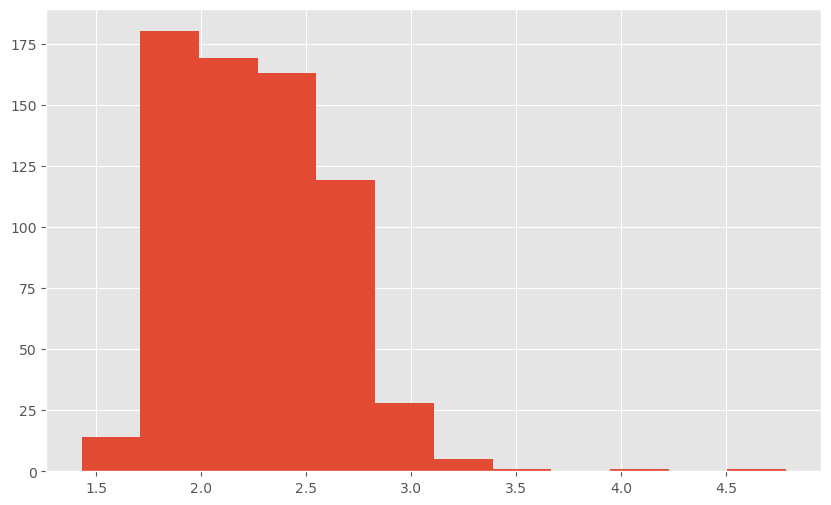

In [29]:
plt.hist(metal['q'], 12)

Metallic asteroids have an approximately normal distribution between 1.5 and 3.25 AU. This is consistent with our intital hypotheses as this distance captures the asteriod belt between the earth and mars. Some outliers exist near the orbital path of jupiter, which are expected as there are clusters in jupiter's orbital path. The distribution is skewed to the right, and due to the low standard deviation of the sample, has a tall and narrow curve.
These results are excellent as it indicates the greatest concentrations of metallic asteroids are relatively close to the earth, and most metallic asteroids overall are clustered together. 

In [30]:
# Examining size of metallic asteroids by diameter
print("Statistics on metallic asteroid diameters. \nNote: units are in kilometers")
print(metal['diameter'].describe())

Statistics on metallic asteroid diameters. 
Note: units are in kilometers
count    681.000000
mean      36.201852
std       40.597596
min        3.367000
25%        9.135000
50%       21.170000
75%       45.298000
max      253.051000
Name: diameter, dtype: float64


(array([318., 132.,  79.,  44.,  29.,  23.,  15.,  11.,   5.,  10.,   4.,
          4.,   1.,   2.,   2.,   2.]),
 array([  3.367  ,  18.97225,  34.5775 ,  50.18275,  65.788  ,  81.39325,
         96.9985 , 112.60375, 128.209  , 143.81425, 159.4195 , 175.02475,
        190.63   , 206.23525, 221.8405 , 237.44575, 253.051  ]),
 <BarContainer object of 16 artists>)

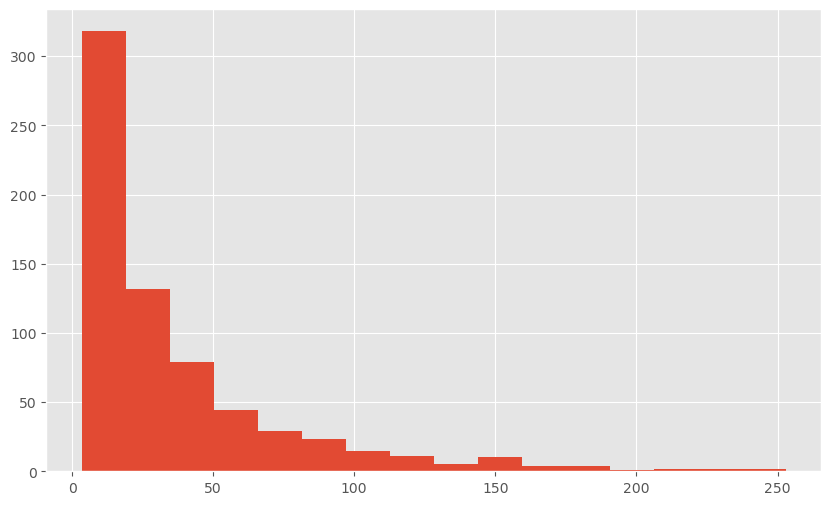

In [34]:
plt.hist(metal['diameter'], 16)

Asteroids appear to not have a normal distribution of size, and instead have a single tailed distribution. It is noteworthy to recognize that even the smallest observation here is over 3km in diameter, so all of the common, small asteroids would still be useful for mineral extraction. Larger asteroids of 75km or larger may be better for mining, as their microgravity would be significantly stronger, though this benefit may be negligable. Larger asteroids would also have geater surface area, allowing more potential landing sites so companies could pick between more landing sites to ensure safe operation. 

<AxesSubplot:xlabel='q', ylabel='diameter'>

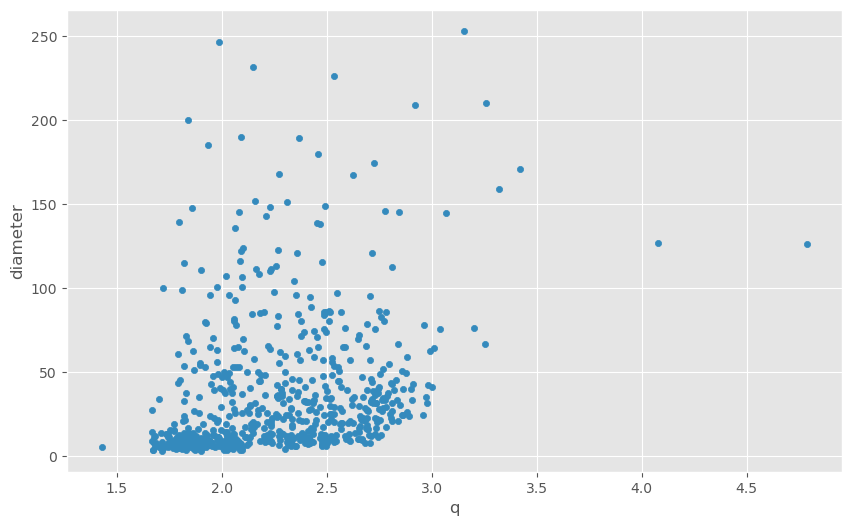

In [40]:
metal.plot.scatter('q', 'diameter')

Plotting both of these variables shows that as distance passes about 2.75 AU, small asteroids quickly become less common, and the furthest asteroids are all well beyond the mean of the sample. It also reveals in the 1.75-2.75 AU area previously identified, medium and large asteroids are equally common throught despite small asteroids being significantly more common. 

## --Testing Code, early analysis and unfinished code blocks--
### [REMOVE BEFORE FINAL SUBMISSION]

In [ ]:
# ---- Part 0 testing
# print(astro.head())
# print(len(astro2))

# ----Part 1 testing 
# astro.head()

# From this we can see that there are some other M class asteroids in combinded classes,
# However, including these only increases the sample from 37 to 41, and includes ambigous
# and/or noisy cases, which would not benefit our model


# astro['diameter'].describe()
# mtype = astro.loc[astro['spec_T'] == "M"]
# mtype['albedo'].describe()
# astro['spec_B'].unique()
# uniques = astro['spec_T'].unique()
# for x in uniques:
#     print(type(x))
#     print(x)


# metal = astro.loc[(astro['spec_T'].str.contains('M')) | (astro['spec_B'].str.contains('X'))]
# metal.shape
# metal = astro.loc[(astro['spec_T'] == "M") | (astro['spec_B'] == 'X') |
#                  (astro['spec_B'] == 'Xc') | (astro['spec_B'] == 'Xe')]
# metal.shape

# unknowns = astro.loc[(astro['spec_T'].isnull()) & (astro['spec_B'].isnull())]
# print(unknowns.shape)

# astro['spec_T'].unique()
# print(astro.shape)
# print(metal.shape)
# astro[astro['spec_T'] == 'nan']
# print(*astro['spec_T'].value_counts())

# astro['n_obs_used'].describe()


# ---- Modeling testing
# X.head()
# ((astro['spec_T'].notnull()) | (astro['spec_B'].notnull()) & astro['albedo'].notnull())
# (astro['spec_T'].notnull()) | (astro['spec_B'].notnull())